# Introduzione <a id="intro"></a>

Il presente progetto è stato sviluppato nell'ambito del corso di Fondamenti di Analisi dei Dati. L'obiettivo principale del progetto è applicare le tecniche e i metodi appresi durante il corso per analizzare un dataset reale, estrapolare informazioni significative, generare intuizioni utili relative alla classificazione. L'analisi si concentrerà su vari aspetti dei dati, tra cui la pulizia e la preparazione dei dati, l'analisi esplorativa...

Il dataset assegnato per questa analisi è l'Internet Advertisement dataset, un insieme di dati che rappresenta un insieme di possibili annunci pubblicitari su pagine Internet. Il compito principale associato a questo dataset è prevedere se un'immagine è un annuncio pubblicitario ("ad") o meno ("nonad").

## Indice:
* [Descrizione del Dataset](#descr-dataset)
* [Caricamento dei dati](#caricamento-dati)
    * [Acquisizione del Dataset](#acquisizione-dataset)
* [Pre-processing dei dati](#pre-processing)
    * [Gestione valori mancanti](#valori-mancanti)
* [Analisi dei dati ](#analisi-dati)
    * [Statistiche Descrittive](#statistiche-descrittive)
    * [Distribuzione dei dati](#distribuzione-dati)
    * [Outliers](#outliers)
* [Bilanciamento del dataset](#bilanciamento-dataset)
* [Riduzione di dimensionalità](#riduzione-dimensionalità)


# Descrizione del Dataset <a id="descr-dataset"></a>

Internet Advertisement Dataset è stato generato tra aprile e luglio 1998. È composto da 3279 istanze, di cui 2821 sono classificate come "nonad" e 458 come "ad". Ogni istanza è descritta da 1558 attributi, di cui 3 continui e il resto binari. Gli attributi continui possono essere mancanti nel 28% delle istanze secondo quanto segnalato nella documentazione. Di seguito si propone uno schema della sua struttura:
* Nome del Dataset: Internet Advertisement Dataset
* Origine: Creato da Nicholas Kushmerick tra aprile e luglio 1998.
* Numero di Istanze: 3279 istanze, suddivise in 2821 "nonad" e 458 "ad".
* Numero di Attributi: 1558 attributi, di cui 3 continui e il resto binari costituiti da variabily dummy, raggruppabili in "url", "origurl", "ancurl", "alt" e "caption".
* Valori Mancanti: Il 28% delle istanze manca di uno o più attributi continui.
* Descrizione degli Attributi: Gli attributi continui codificano la geometria dell'immagine (se disponibile); Gli attributi binari sono relativi alla presenza o meno di frasi che si verificano nell'URL dell'immagine, nell'URL e nel testo alternativo dell'immagine, nel testo dell'ancora e nelle parole che si verificano vicino al testo dell'ancora.

Si noti inoltre che non è presente una suddivisione in train e test set prestabilita dagli autori del dataset. Il dataset viene distribuito secondo la seguente struttura:
* ad.names, qui sono presenti tutti i nomi dei 1558 attributi presenti;
* ad.data, qui sono presenti tutti i 3279 records del dataset;
* ad.DOCUMENTATION: documentazione distribuita insieme al dataset.

# Caricamento dei Dati <a id="caricamento-dati"></a>

## Imports

In [1]:
# Install requirements
%pip install --user -qr ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from statsmodels.formula.api import ols
from sklearn.metrics import mean_absolute_error
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score


## Acquisizione del Dataset <a id="acquisizione-dataset"></a>

Di seguito si procede ad acquisire il dataset. Si utilizza l'encoding ISO-8859-1 a causa di alcuni caratteri non standard nel file.

In [3]:
with open('ad.names', encoding='ISO-8859-1') as fp:
    cols = []
    for line in fp:
        line = line.strip()
        if line.endswith(': continuous.') or line.endswith(': 0,1.'):
            colname = line.split(':')[0]
            cols.append(colname)
    cols.append('Class')

In [4]:
# Viene caricato il dataset utilizzando i nomi delle colonne estratte dal file 'ad.names'
options = {
    'header': None, # il file non ha riga di intestazione
    'names': cols, 
    'skipinitialspace': True, # riumuove eventuali spazi bianchi iniziali
    'low_memory': False}
df = pd.read_csv('ad.data', **options)

In [5]:
# Stampa righe del dataset per osservare la struttura dati
df

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Class
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,?,?,?,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


In [6]:
df.dtypes

height                object
width                 object
aratio                object
local                 object
url*images+buttons     int64
                       ...  
caption*here           int64
caption*click          int64
caption*for            int64
caption*you            int64
Class                 object
Length: 1559, dtype: object

I valori mancanti vengono indicati con '?' nel dataset, per cui per essere elaborati con pandas, vengono sostituiti con nan.

In [7]:
columns_with_question_mark = (df == "?").any()
columns_with_question_mark[columns_with_question_mark].index

Index(['height', 'width', 'aratio', 'local'], dtype='object')

In [8]:
df = df.replace('?', np.nan)

Viene impostato il tipo corretto per le feature che presentavano valori mancanti

In [9]:
df['height'] = df['height'].astype(float)
df['width'] = df['width'].astype(float)
df['aratio'] = df['aratio'].astype(float)
df['local'] = df['local'].astype(float)

# Pre-processing dei dati <a id="pre-processing"></a>

## Mappatura Classi

La variabile categorica Class è un object, ma è una variabile binaria, dunque si decide di cambiare il type da object ad int con:
* 0 = nonad.
* 1 = ad.

In [10]:
df['Class'] = df['Class'].map({'nonad.': 0, 'ad.': 1}).astype(int)

## Split train e test set

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [12]:
print(train_set.shape)
print(test_set.shape)

(2623, 1559)
(656, 1559)


## Gestione valori mancanti <a id="valori-mancanti"></a>

### Test Set

Per il test set, si procede all'eliminazione dei records con valori mancanti.

In [13]:
test_set.isna().sum()

height                184
width                 184
aratio                186
local                   3
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
Class                   0
Length: 1559, dtype: int64

In [14]:
test_set.dropna(inplace=True)

In [15]:
test_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
Class                 0
Length: 1559, dtype: int64

In [16]:
test_set['local'] = test_set['local'].astype(int)
test_set.shape

(467, 1559)

### Train Set

Verifica dei valori mancanti come indicato dalla documentazione

In [17]:
train_set.isna().sum()

height                719
width                 717
aratio                724
local                  12
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
Class                   0
Length: 1559, dtype: int64

In [18]:
columns_with_missing_values = train_set.isna().sum() > 0
columns_with_missing_values[columns_with_missing_values]

height    True
width     True
aratio    True
local     True
dtype: bool

Come ci si aspettava rispetto alla documentazione, il dataset presenta diversi dati mancanti, di seguito il totale dei record affetti:

In [19]:
missing_data_rows = (train_set.isna().sum(axis=1) > 0).sum()
print(missing_data_rows)
print(str(round(missing_data_rows * 100 / train_set.shape[0], 2)) + "%")

731
27.87%


#### Height, Width, Aratio

In [20]:
print(round(train_set.loc[1, 'width'] / train_set.loc[1, 'height'], 4), train_set.loc[1, 'aratio'])

1.0 1.0


Considerato che:
* I valori mancanti si concentrano nelle features `Height`, `Width`, `Arazio`;
* `arazio = width/height`

ci si occuperà di gestire i valori mancanti in height e width per poi ricavare arazio da essi.

Di seguito il numero di records con le features height, width, aratio con dati mancanti:

In [21]:
(train_set[['height', 'width', 'aratio']].isna().any(axis=1)).sum()

724

Metodi per la loro gestione:

* **Eliminazione diretta delle colonne**: Come si nota, le features principalmente affette sono quelle con dati continui relative alle immagini. Una soluzione potrebbe essere l'eliminazione di `height`, `width` e `aratio`.

* **Eliminazione records**: Eliminare direttamente le righe con dati mancanti. Soluzione indicata per poche righe con dati mancanti, in questo caso si andrebbero ad eliminare 910 records, ovvero 27.75% del totale.

* **Imputazione con la media o mediana**: avendo grossa parte dei valori mancanti, la media stimata potrebbe discostarsi di molto da quella effettiva;

* **Imputazione con moda**: viene mantenuta l'indipendenza delle osservazioni (le adv sono indipendenti per ogni record), non ha bisogno di ordinamenti, di contro si potrebbe sovrastimare la frequenza di caratteristiche comuni.

* **Imputazione KNN**: Le osservazioni sono considerate come punti nello spazio delle features e i valori mancanti sono stimati sulla base dei k vicini più prossimi.


Si è deciso di procedere con l'imputazione della moda per height e width e ricavare da essa aratio.

In [22]:
height_mode = train_set['height'].mode()[0]
width_mode = train_set['width'].mode()[0]

# Imputo i valori mancanti
train_set['height'].fillna(height_mode, inplace=True)
train_set['width'].fillna(width_mode, inplace=True)
train_set['aratio'].fillna(width_mode/height_mode, inplace=True)

#### Local

Di seguito i records con la feature local con dati mancanti:

In [23]:
(train_set[['local']].isna().any(axis=1)).sum()

12

Considerando che sono solo 15 i record con local indefinito, per cui lo 0.45% del totale, si procede all'eliminazione di questi records.

In [24]:
train_set = train_set.dropna(subset=['local'])
train_set['local'] = train_set['local'].astype(int)

Osservazione dati puliti

In [25]:
train_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
Class                 0
Length: 1559, dtype: int64

# Analisi dei dati <a id="analisi-dati"></a>

Dalla prima revisione è emerso che visualizzare i dati è possibile facilmente solo per le variabili continue, meno per le variabili dummy. Provare a fare un conteggio degli 1 e zero per ogni variabile per capire quanto sparso è il dataset.

## Statistiche Descrittive <a id="statistiche-descrittive"></a>

In [26]:
pd.set_option('display.max_columns', None)
train_set.describe(include='all')

height        width       aratio        local  url*images+buttons  \
count  2611.000000  2611.000000  2611.000000  2611.000000         2611.000000   
mean     62.596323   239.290693     4.926099     0.771352            0.004213   
std      47.397886   177.487901     5.051376     0.420042            0.064783   
min       1.000000     1.000000     0.001500     0.000000            0.000000   
25%      32.000000    90.000000     1.296400     1.000000            0.000000   
50%      60.000000   150.000000     4.500000     1.000000            0.000000   
75%      60.000000   468.000000     7.800000     1.000000            0.000000   
max     640.000000   640.000000    60.000000     1.000000            1.000000   

       url*likesbooks.com  url*www.slake.com  url*hydrogeologist      url*oso  \
count         2611.000000        2611.000000         2611.000000  2611.000000   
mean             0.012256           0.004979            0.003064     0.003447   
std              0.110047           0.070399            0.055279     0.058621   
min              0.000000           0.000000            0.000000     0.000000   
25%              0.000000           0.000000            0.000000     0.000000   
50%              0.000000           0.000000            0.000000     0.000000   
75%              0.000000           0.000000            0.000000     0.000000   
max              1.000000           1.000000            1.000000     1.000000   

         url*media  url*peace+images  url*blipverts  url*tkaine+kats  \
count  2611.000000       2611.000000    2611.000000      2611.000000   
mean      0.011107          0.003447       0.003064         0.008809   
std       0.104822          0.058621       0.055279         0.093459   
min       0.000000          0.000000       0.000000         0.000000   
25%       0.000000          0.000000       0.000000         0.000000   
50%       0.000000          0.000000       0.000000         0.000000   
75%       0.000000          0.000000       0.000000         0.000000   
max       1.000000          1.000000       1.000000         1.000000   

       url*labyrinth  url*advertising+blipverts  url*images+oso  \
count    2611.000000                2611.000000     2611.000000   
mean        0.005362                   0.003064        0.003447   
std         0.073043                   0.055279        0.058621   
min         0.000000                   0.000000        0.000000   
25%         0.000000                   0.000000        0.000000   
50%         0.000000                   0.000000        0.000000   
75%         0.000000                   0.000000        0.000000   
max         1.000000                   1.000000        1.000000   

       url*area51+corridor  url*ran+gifs  url*express-scripts.com     url*off  \
count          2611.000000   2611.000000              2611.000000  2611.00000   
mean              0.005362      0.003064                 0.005745     0.00383   
std               0.073043      0.055279                 0.075592     0.06178   
min               0.000000      0.000000                 0.000000     0.00000   
25%               0.000000      0.000000                 0.000000     0.00000   
50%               0.000000      0.000000                 0.000000     0.00000   
75%               0.000000      0.000000                 0.000000     0.00000   
max               1.000000      1.000000                 1.000000     1.00000   

          url*cnet  url*time+1998  url*josefina3  url*truluck.com  \
count  2611.000000    2611.000000    2611.000000      2611.000000   
mean      0.002681       0.004213       0.004213         0.005362   
std       0.051718       0.064783       0.064783         0.073043   
min       0.000000       0.000000       0.000000         0.000000   
25%       0.000000       0.000000       0.000000         0.000000   
50%       0.000000       0.000000       0.000000         0.000000   
75%       0.000000       0.000000       0.000000         0.000000   
max       1.00000

Principali considerazioni:
* **height e width**: media width (241.20) è molto superiore media height (62.93), con std maggiore nella dimensione orizzontale rispetto a quella verticale.
* **aratio**: Il valore medio è 4.99, indicando che l'ampiezza è mediamente circa cinque volte l'altezza. Std elevata.
* **local**: Colonna binaria con un valore medio di 0.76, suggerendo che la maggior parte dei valori assunti è 1.
* La quasi totalità delle variabili categoriche binarie ha una media molto piccola in valore, suggerendo che la maggior parte dei valori assume 0, dunque il dataset risulta sparso.

 ## Distribuzione dei dati <a id="distribuzione-dati"></a>

### Distribuzione delle classi

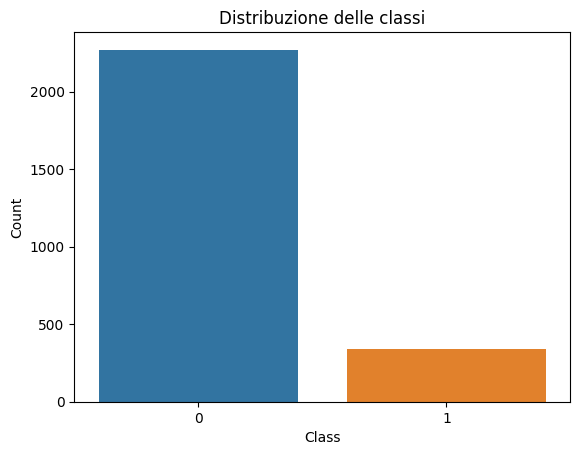

In [27]:
sns.countplot(data=train_set, x='Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribuzione delle classi')
plt.show()

Come si può apprezzare, il dataset risulta fortemente sbilanciato verso le Class "nonad.", ottenendo molti meno campioni per "ad.". In una sezione successiva si valuteranno tecniche di bilanciamento del dataset.

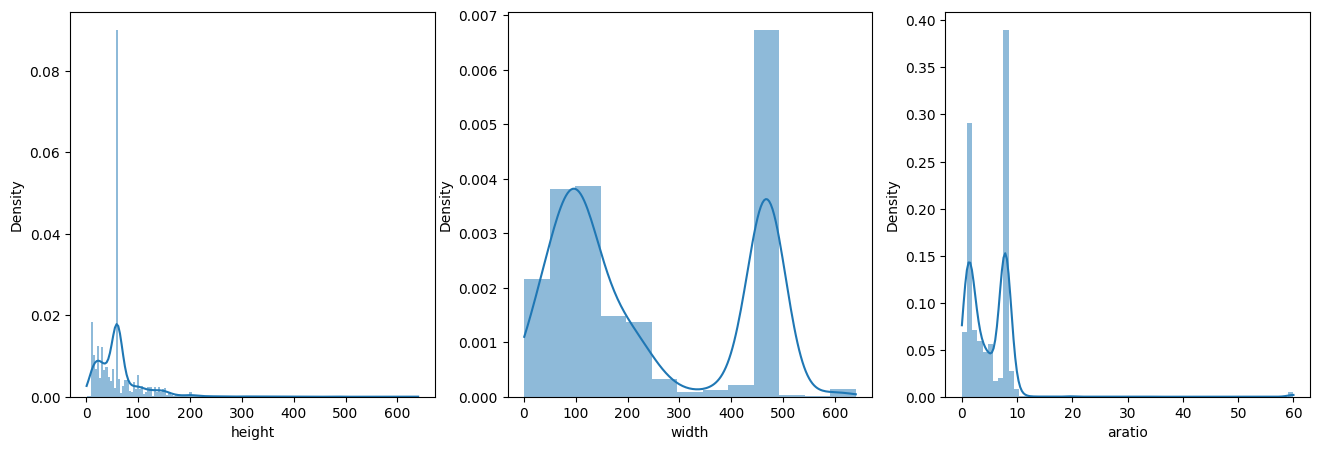

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(16)

sns.histplot(train_set['height'], kde=True, stat="density", linewidth=0, ax=ax[0])
sns.histplot(train_set['width'], kde=True, stat="density", linewidth=0, ax=ax[1])
sns.histplot(train_set['aratio'], kde=True, stat="density", linewidth=0, ax=ax[2])

plt.show()

Si nota in parte una positive skew per le variabili continue

<Axes: >

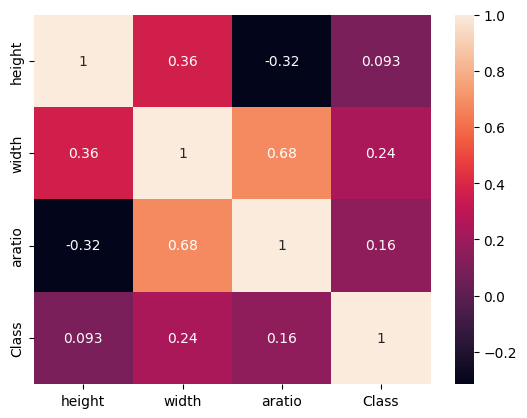

In [29]:
sns.heatmap(train_set.iloc[:,[0,1,2,1558]].corr(method="spearman"),annot=True)

Si può notare una buona correlazione (Pearson) tra le variabili continue inerenti alle immagini.

In [30]:
# Raggruppa le variabili dummy in cluster
url_features = train_set[[col for col in train_set.columns if col.startswith('url*')]]
origurl_features = train_set.filter(like='origurl*')
ancurl_features = train_set.filter(like='ancurl*')
alt_features = train_set.filter(like='alt*')
caption_features = train_set.filter(like='caption*')

# Lista dei cluster e corrispondenti nomi dei cluster
clusters = [url_features, origurl_features, ancurl_features, alt_features, caption_features]
cluster_names = ['url', 'origurl', 'ancurl', 'alt', 'caption']

# Creazione della figura interattiva con sottoplot per ogni cluster
fig = make_subplots(rows=len(clusters), cols=1, subplot_titles=cluster_names)

# Aggiunta dei grafici a barre interattivi per ogni cluster
for i, cluster in enumerate(clusters):
    counts = cluster.sum()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, hovertemplate="Class: %{x}<br>Occorrenze di 1: %{y}"), row=i+1, col=1)

# Aggiunta dei titoli e impostazioni del layout
fig.update_layout(height=500*len(clusters), title_text="Numero di occorrenze di 1 per cluster di variabili dummy")
fig.update_xaxes(tickangle=45, tickfont=dict(size=8), showgrid=False)
fig.update_yaxes(title_text="Numero di occorrenze di 1")

fig.show()


Come si può osservare, il dataset risulta molto sparso, poche variabili superano il 4% dei records nel numero di occorrenze.

## Outliers <a id="outliers"></a>

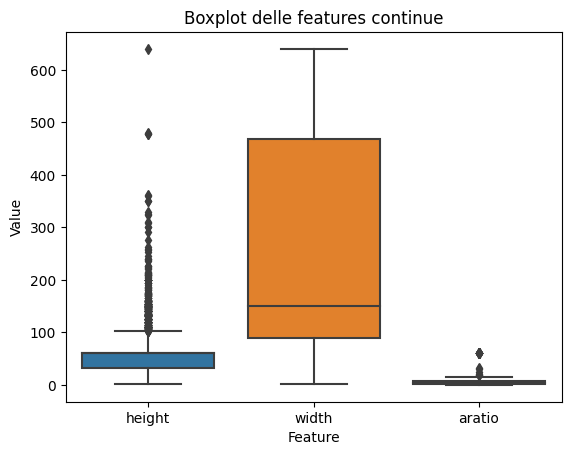

In [31]:
sns.boxplot(data=train_set.iloc[:, :3])
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot delle features continue')
plt.show()

Vengono valutati gli outlier per le variabili continue: la prima componente presenta possibili outlier che andrebbero indagati, comunque i valori rientrano nell'intorno di width.

# Riduzione di dimensionalità <a id="riduzione-dimensionalità"></a>

## Perfetta Multicollinearità

La perfetta multicollinearità è una situazione in cui due o più variabili indipendenti in un modello di regressione multivariata sono linearmente correlate esattamente. In altre parole, una variabile può essere espressa come una combinazione lineare esatta delle altre. Matematicamente, per esempio, se avessimo tre variabili \(X_1\), \(X_2\) e \(X_3\), avremmo una situazione di perfetta multicollinearità se esistesse una relazione del tipo \(X_1 = aX_2 + bX_3\), dove \(a\) e \(b\) sono costanti.

Si è sperimentato nelle sezioni successive che la presenza di multicollinearità perfetta può causare problemi nei modelli di regressione, poiché può portare a stime dei coefficienti instabili e ad un'interpretazione problematica delle variabili.

Si analizza dunque la presenza di perfetta multicollinearità nel dataset.

In [32]:
# Calcola la matrice di correlazione
correlation_matrix = train_set.corr()

# Trova le coppie di colonne correlate
correlated_pairs = {}
for col in correlation_matrix.columns:
    for idx in correlation_matrix.index:
        if idx == col:
            continue
        correlation = correlation_matrix.loc[idx, col]
        if correlation == 1.0 or correlation == -1.0:
            # Seleziona la coppia di colonne con correlazione esatta
            if col not in correlated_pairs and idx not in correlated_pairs:
                correlated_pairs[col] = idx

# Stampare le coppie di variabili
print("Numero di coppie perfettamente correlate: ", len(correlated_pairs))
# for key, value in correlated_pairs.items():
#     print(key, value)

for col1, col2 in correlated_pairs.items():
     print(col1, col2)

Numero di coppie perfettamente correlate:  817
url*likesbooks.com url*www.likesbooks.com
url*www.slake.com url*slake.com
url*hydrogeologist url*hydrogeologist+imgs
url*oso url*images+oso
url*blipverts url*advertising+blipverts
url*labyrinth url*area51+labyrinth
url*advertising+blipverts url*wired.com
url*images+oso url*website.ora.com
url*area51+corridor url*corridor
url*express-scripts.com url*www.express-scripts.com
url*off url*off+gif
url*time+1998 url*time
url*josefina3 origurl*josefina3
url*truluck.com url*www.truluck.com
url*clawnext+gif url*clawnext
url*autopen.com url*www.autopen.com
url*pixs url*fools+pixs
url*heartland+5309 origurl*heartland+5309
url*www.internauts.ca url*internauts.ca
url*afn.org url*www.afn.org
url*ran.org url*www.ran.org
url*shareware.com url*www.shareware.com
url*baons+images url*theinternetadvantage.com
url*area51+labyrinth url*labyrinth+9439
url*image+navigate url*navigate+b
url*pool+images url*www.toyotaofroswell.com
url*carousel.org url*www.carousel.o

Come si puà notare dall'output sopra, esistono diverse coppie di variabili che sono affette da perfetta multicollinearità. Si nota inoltre che spesso queste coppie fanno riferimento ad una stringa comune all'interno delle variabili. Si sceglie dunque di mantenere solo una di queste variabili, effettuando feature selection sulla base della correlazione perfetta tra le variabili in esame.

In [33]:
# Rimuove una variabile da ciascuna coppia altamente correlata sia dal train set che dal test set
train_set_reduced = train_set.drop(columns=correlated_pairs.keys())
test_set_reduced = test_set.drop(columns=correlated_pairs.keys())
print(train_set_reduced.shape)

(2611, 742)


## PCA

Il numero di feature è ancora molto alto, dunque si è scelto di valutare una riduzione delle features tramite PCA per effettuare un'analisi completa. Le variabili dummy sono raggruppabili in cluster come segue: url, origurl, ancurl, alt, caption.

Si definiscono le seguenti funzioni ausiliarie:

In [34]:
def show_pca_var_plot(pca, cluster_title):
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5,
            align='center', label=cluster_title + ' individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    plt.show()

In [35]:
def apply_pca(train_df, test_df, n_components=0.70, show_plots=False):
    feature_groups = {
        "url": [col for col in train_df.columns if col.startswith('url*')],
        "origurl": [col for col in train_df.columns if 'origurl*' in col],
        "ancurl": [col for col in train_df.columns if 'ancurl*' in col],
        "alt": [col for col in train_df.columns if 'alt*' in col],
        "caption": [col for col in train_df.columns if 'caption*' in col]
    }

    # Apply PCA to each feature group
    pca_models = {}
    for group_name, features in feature_groups.items():
        pca = PCA(n_components=n_components)
        pca.fit(train_df[features])  # Fit PCA on training data
        pca_models[group_name] = pca  # Save the PCA model

    # Transform both training and test data using the fitted PCA models
    for df in [train_df, test_df]:
        pca_features = []
        for group_name, features in feature_groups.items():
            pca_result = pca_models[group_name].transform(df[features])
            if show_plots and df is train_df:
                show_pca_var_plot(pca_models[group_name], group_name)
            pca_features.append(pca_result)

        # Concatenate the PCA-transformed feature clusters back together
        pca_df = pd.DataFrame(
            np.concatenate([
                df[['height', 'width', 'aratio', 'local']].to_numpy(), 
                *pca_features,
                df[['Class']].to_numpy()
            ], axis=1)
        )

        # Add column names
        column_names = ['height', 'width', 'aratio', 'local']

        for (group, pca_result) in zip(feature_groups.keys(), pca_features):
            for i in range(pca_result.shape[1]):
                column_names.append(f"{group}_c{i}")

        column_names.append('Class')
        pca_df.columns = column_names
        pca_df['local'] = pca_df['local'].astype(int)
        pca_df['Class'] = pca_df['Class'].astype(int)

        if df is train_df:
            train_pca_df = pca_df
        else:
            test_pca_df = pca_df

    return train_pca_df, test_pca_df

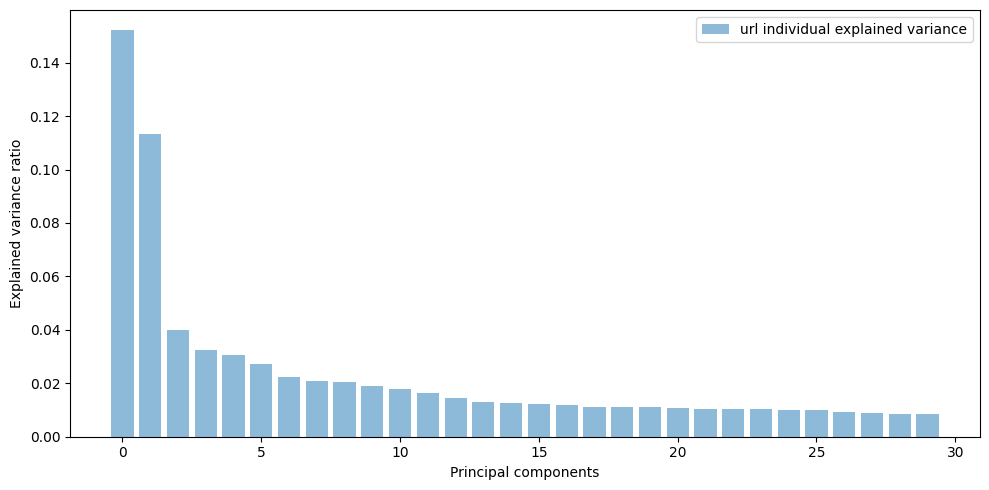

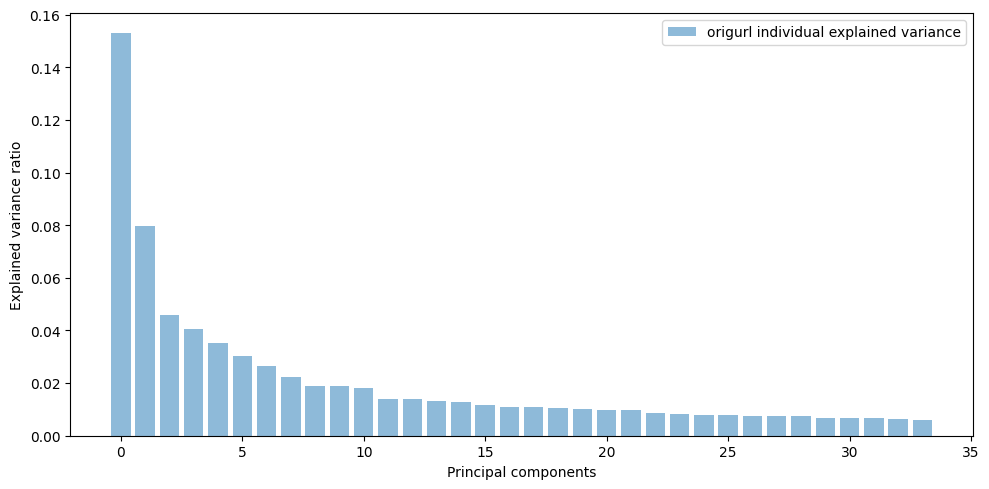

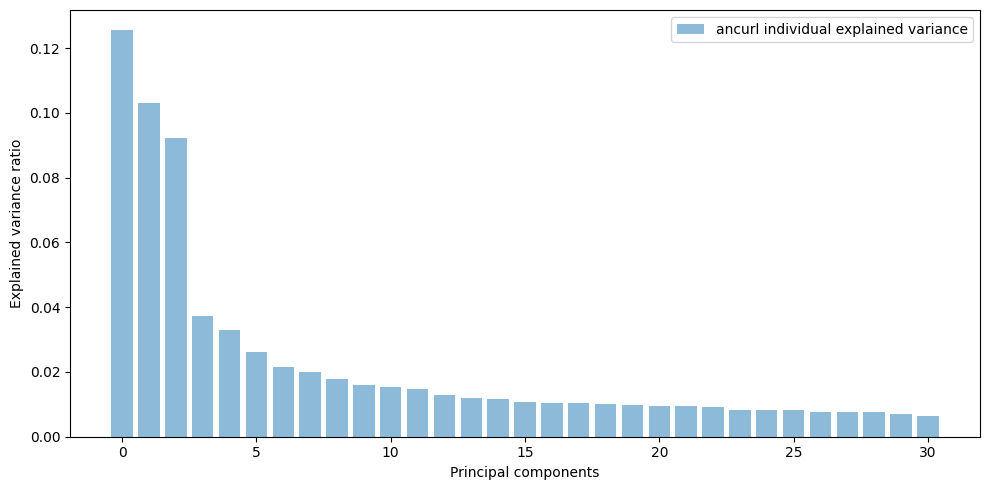

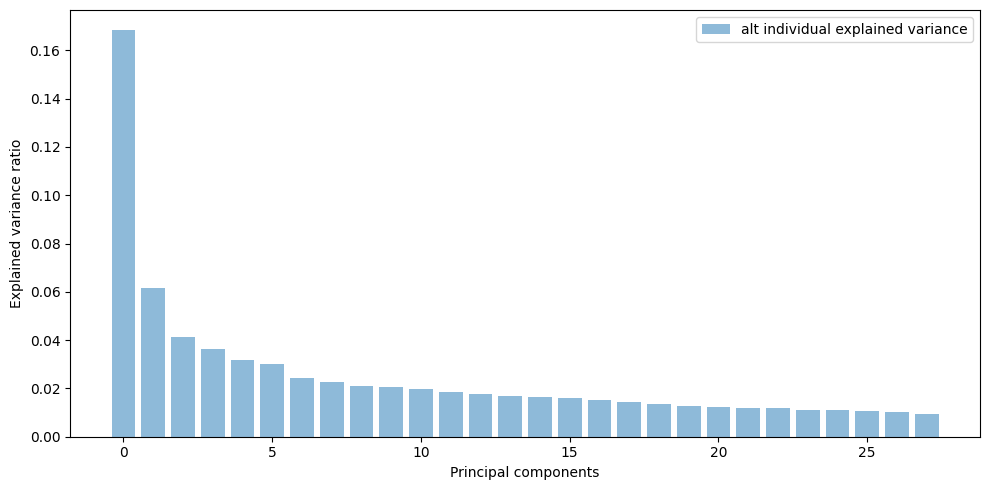

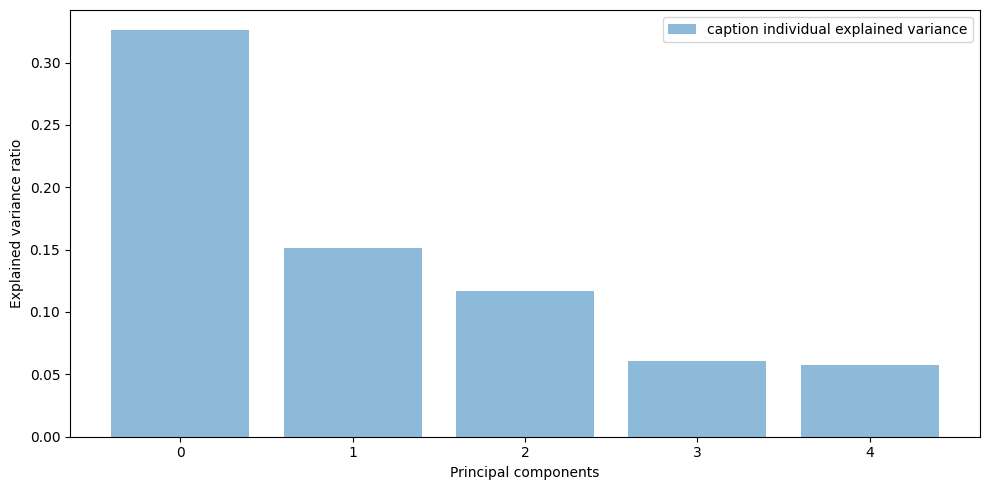

133


In [99]:
pca_train_set, pca_test_set = apply_pca(train_set_reduced, test_set_reduced, n_components=0.70, show_plots=True) # Keep 70% of variance
print(len(pca_train_set.columns))

Grafico a barre che mostra quanta varianza è spiegata da ciascuna componente principale. Si è ottenuta una sostanziale riduzione delle features.

# Regressione e Classificazione <a id="regressione"></a>

Nel prossimo capitolo, si esaminerà l'applicazione delle tecniche di regressione al dataset fornito. Si rende necessario utilizzare il dateset ottenuto tramite riduzione delle variabily dummi a variabili categoriche e quello ottenuto dall'analisi delle componenti principali (PCA), poiché il numero di variabili indipendenti nel dataset originale sarebbe eccessivo e richiederebbe tempi di calcolo proibitivi. Si verifica facilmente l'errore di 'maximum recursion depth exceeded'.

Le prestazioni degli algoritmi saranno valutate in termini di Accuracy, Precision, Recall ed F1 score, verrà inoltre visualizzata la matrice di cofusione. Si definisce per lo scopo la seguente funzione:

In [73]:
classes = ["noadv",  "adv"]
def metrics_printer(Y_train, pred_train, Y_test, pred_test):
    fig, axs = plt.subplots(2, 2, figsize=(30,30))

    for idx, (Y, pred, title) in enumerate(zip([Y_train, Y_test], [pred_train, pred_test], ["Train Score", "Test Score"])):
        cf_matrix = confusion_matrix(Y, pred)
        sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels=classes, cmap='cividis',
                    yticklabels=classes, ax=axs[0, idx]).set_title(title)
        
        metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
        results = [accuracy_score(Y, pred), 
                   precision_score(Y, pred), 
                   recall_score(Y, pred), 
                   f1_score(Y, pred)]
        
        g = sns.barplot(x=metrics, y=results, ax=axs[1, idx])
        g.set_yticks(np.arange(0, 1.01, 0.05))
        
    print(accuracy_score(Y_test, pred_test))

## Logistic

In [102]:
def backward_elimination_logistic(train_data, target_variable):
    feature_string = '+'.join([feature for feature in train_data.columns if feature != target_variable])
    formula = target_variable + " ~ " + feature_string
    regression_model = logit(formula, train_data).fit_regularized(alpha=1.0, L1_wt=0.0)

    eliminated_features = []
    x_vars = feature_string.split("+")

    while regression_model.pvalues.drop("Intercept").max() > 0.1:
        feature_to_remove = regression_model.pvalues.drop("Intercept").idxmax()
        eliminated_features.append(feature_to_remove)
        x_vars.remove(feature_to_remove)
        # print("feature_to_remove: ", feature_to_remove)
        # print("value: ", regression_model.pvalues.drop("Intercept").max())
        # print("new x_vars: ", x_vars)
        # print()
        formula = target_variable + " ~ " + '+'.join(x_vars)
        regression_model = logit(formula, train_data).fit_regularized(alpha=1.0, L1_wt=0.0)
    
    return regression_model, eliminated_features

def perform_logistic_regression(train_data, dependent_variable):
    regression_model, eliminated_features = backward_elimination_logistic(train_data, dependent_variable)
    print("Eliminated features: ", eliminated_features)
    print(regression_model.summary())
    
    return regression_model


In [105]:
def replace_special_chars(column_name):
    mapping = {
        '.': '_dot_',
        '+': '_plus_',
        '®': '_registered_',
        '-': '_minus_',
        '*': '_asterisk_'
    }
    for special_char, replacement in mapping.items():
        column_name = column_name.replace(special_char, replacement)
    return column_name

# Sostituzione dei caratteri speciali nei nomi delle colonne
train_data = test_set_reduced.copy()
train_data.columns = [replace_special_chars(col) for col in train_data.columns]

test_data = test_set_reduced.copy()
test_data.columns = [replace_special_chars(col) for col in test_data.columns]

perform_logistic_regression(train_data, dependent_variable="Class")

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



KeyboardInterrupt: 

In [103]:
pca_model = perform_logistic_regression(pca_train_set, dependent_variable="Class")

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13548779536206437
            Iterations: 456
            Function evaluations: 466
            Gradient evaluations: 456


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.135487795770038
            Iterations: 443
            Function evaluations: 452
            Gradient evaluations: 443


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13548780888311152
            Iterations: 446
            Function evaluations: 456
            Gradient evaluations: 446


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13548800510020095
            Iterations: 437
            Function evaluations: 446
            Gradient evaluations: 437


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 130 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13548799765508224
            Iterations: 444
            Function evaluations: 454
            Gradient evaluations: 444


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1354880991724374
            Iterations: 456
            Function evaluations: 465
            Gradient evaluations: 456


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1354883712761596
            Iterations: 433
            Function evaluations: 442
            Gradient evaluations: 433


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 127 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13548840180304783
            Iterations: 447
            Function evaluations: 457
            Gradient evaluations: 447


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1354906941985697
            Iterations: 431
            Function evaluations: 440
            Gradient evaluations: 431


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13549466059318968
            Iterations: 444
            Function evaluations: 453
            Gradient evaluations: 444


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13549919264534938
            Iterations: 448
            Function evaluations: 457
            Gradient evaluations: 448


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13550627273218685
            Iterations: 448
            Function evaluations: 458
            Gradient evaluations: 448


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13551042030243476
            Iterations: 441
            Function evaluations: 451
            Gradient evaluations: 441


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1355149998831451
            Iterations: 459
            Function evaluations: 468
            Gradient evaluations: 459


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553367429819446
            Iterations: 416
            Function evaluations: 425
            Gradient evaluations: 416


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 119 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553366740830108
            Iterations: 418
            Function evaluations: 427
            Gradient evaluations: 418


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553364333525297
            Iterations: 424
            Function evaluations: 433
            Gradient evaluations: 424


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 117 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553364497722747
            Iterations: 433
            Function evaluations: 442
            Gradient evaluations: 433


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 116 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553364308299878
            Iterations: 424
            Function evaluations: 433
            Gradient evaluations: 424


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 115 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553365501665418
            Iterations: 409
            Function evaluations: 418
            Gradient evaluations: 409


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 114 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553367336819014
            Iterations: 417
            Function evaluations: 426
            Gradient evaluations: 417


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 113 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1355336919490155
            Iterations: 409
            Function evaluations: 418
            Gradient evaluations: 409


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 112 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553366983596593
            Iterations: 416
            Function evaluations: 426
            Gradient evaluations: 416


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 111 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553367524913296
            Iterations: 403
            Function evaluations: 413
            Gradient evaluations: 403


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 110 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553365853594032
            Iterations: 409
            Function evaluations: 418
            Gradient evaluations: 409


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.135533722777645
            Iterations: 407
            Function evaluations: 416
            Gradient evaluations: 407


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 108 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553370000096693
            Iterations: 404
            Function evaluations: 413
            Gradient evaluations: 404


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 107 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13553367376113704
            Iterations: 407
            Function evaluations: 416
            Gradient evaluations: 407


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1355506901694571
            Iterations: 401
            Function evaluations: 410
            Gradient evaluations: 401


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13557369976715558
            Iterations: 415
            Function evaluations: 424
            Gradient evaluations: 415


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13560408848126349
            Iterations: 401
            Function evaluations: 410
            Gradient evaluations: 401


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 103 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13560409126657472
            Iterations: 386
            Function evaluations: 396
            Gradient evaluations: 386


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13566532822886385
            Iterations: 410
            Function evaluations: 419
            Gradient evaluations: 410


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1357059152950346
            Iterations: 394
            Function evaluations: 404
            Gradient evaluations: 394


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 100 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13570594311101858
            Iterations: 400
            Function evaluations: 409
            Gradient evaluations: 400


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13574397185384884
            Iterations: 383
            Function evaluations: 393
            Gradient evaluations: 383


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13574576912497122
            Iterations: 395
            Function evaluations: 404
            Gradient evaluations: 395


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13579123903138457
            Iterations: 382
            Function evaluations: 392
            Gradient evaluations: 382


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 96 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13579117969164123
            Iterations: 398
            Function evaluations: 408
            Gradient evaluations: 398


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13589055962414695
            Iterations: 399
            Function evaluations: 409
            Gradient evaluations: 399


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 94 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13589053368618645
            Iterations: 397
            Function evaluations: 406
            Gradient evaluations: 397


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 93 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13589055155852423
            Iterations: 400
            Function evaluations: 410
            Gradient evaluations: 400


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13597552940112542
            Iterations: 386
            Function evaluations: 395
            Gradient evaluations: 386


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 91 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13597555249440474
            Iterations: 381
            Function evaluations: 391
            Gradient evaluations: 381


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13597595695484777
            Iterations: 384
            Function evaluations: 393
            Gradient evaluations: 384


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 89 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13597597022586427
            Iterations: 384
            Function evaluations: 393
            Gradient evaluations: 384


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 88 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13597599096301283
            Iterations: 373
            Function evaluations: 382
            Gradient evaluations: 373


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13603775543213187
            Iterations: 373
            Function evaluations: 382
            Gradient evaluations: 373


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13603774782850014
            Iterations: 375
            Function evaluations: 384
            Gradient evaluations: 375


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1361215330310696
            Iterations: 357
            Function evaluations: 367
            Gradient evaluations: 357


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13627176887204273
            Iterations: 359
            Function evaluations: 368
            Gradient evaluations: 359


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13627193358282932
            Iterations: 346
            Function evaluations: 355
            Gradient evaluations: 346


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 82 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13627194063445425
            Iterations: 353
            Function evaluations: 362
            Gradient evaluations: 353


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13640529940183793
            Iterations: 345
            Function evaluations: 354
            Gradient evaluations: 345


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 80 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1364052692917091
            Iterations: 343
            Function evaluations: 352
            Gradient evaluations: 343


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13666322071569875
            Iterations: 343
            Function evaluations: 352
            Gradient evaluations: 343


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13666371067589794
            Iterations: 343
            Function evaluations: 353
            Gradient evaluations: 343


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1367711086950844
            Iterations: 347
            Function evaluations: 356
            Gradient evaluations: 347


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13690055273766433
            Iterations: 354
            Function evaluations: 363
            Gradient evaluations: 354


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 75 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13690054952570416
            Iterations: 344
            Function evaluations: 354
            Gradient evaluations: 344


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13809797095976353
            Iterations: 329
            Function evaluations: 338
            Gradient evaluations: 329


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 73 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1380979879605901
            Iterations: 340
            Function evaluations: 349
            Gradient evaluations: 340


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13825225769982655
            Iterations: 332
            Function evaluations: 341
            Gradient evaluations: 332


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13845974794501587
            Iterations: 339
            Function evaluations: 348
            Gradient evaluations: 339


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13865982470090746
            Iterations: 332
            Function evaluations: 341
            Gradient evaluations: 332


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13893393558541123
            Iterations: 336
            Function evaluations: 346
            Gradient evaluations: 336


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13938463879386903
            Iterations: 290
            Function evaluations: 300
            Gradient evaluations: 290


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.139384717100237
            Iterations: 302
            Function evaluations: 312
            Gradient evaluations: 302


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13962569728047858
            Iterations: 308
            Function evaluations: 317
            Gradient evaluations: 308


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 65 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1396257082169601
            Iterations: 305
            Function evaluations: 314
            Gradient evaluations: 305


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 64 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.139625716382748
            Iterations: 297
            Function evaluations: 307
            Gradient evaluations: 297


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13993983445879565
            Iterations: 309
            Function evaluations: 319
            Gradient evaluations: 309


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1399428628830044
            Iterations: 323
            Function evaluations: 332
            Gradient evaluations: 323


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 61 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.13994292086675114
            Iterations: 302
            Function evaluations: 312
            Gradient evaluations: 302


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14019024446601425
            Iterations: 309
            Function evaluations: 318
            Gradient evaluations: 309


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 59 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14019024838165792
            Iterations: 310
            Function evaluations: 319
            Gradient evaluations: 310


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14019075673898201
            Iterations: 302
            Function evaluations: 311
            Gradient evaluations: 302


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 57 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.140190728760725
            Iterations: 307
            Function evaluations: 316
            Gradient evaluations: 307


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 56 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14019074041004964
            Iterations: 294
            Function evaluations: 303
            Gradient evaluations: 294


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 55 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14019072432945756
            Iterations: 288
            Function evaluations: 297
            Gradient evaluations: 288


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14071540289322906
            Iterations: 300
            Function evaluations: 309
            Gradient evaluations: 300


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14071544896110594
            Iterations: 302
            Function evaluations: 311
            Gradient evaluations: 302


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1407163751529969
            Iterations: 299
            Function evaluations: 308
            Gradient evaluations: 299


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1408032504447929
            Iterations: 264
            Function evaluations: 271
            Gradient evaluations: 264


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14131604206722198
            Iterations: 263
            Function evaluations: 270
            Gradient evaluations: 263


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 49 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14131600983507467
            Iterations: 264
            Function evaluations: 271
            Gradient evaluations: 264


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14131610216366147
            Iterations: 274
            Function evaluations: 281
            Gradient evaluations: 274


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.14177126113933552
            Iterations: 263
            Function evaluations: 269
            Gradient evaluations: 263


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\statsmodels\discrete\discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1422239276138756
            Iterations: 277
            Function evaluations: 283
            Gradient evaluations: 277
Eliminated features:  ['origurl_c11', 'origurl_c27', 'url_c5', 'url_c12', 'alt_c3', 'origurl_c17', 'url_c8', 'ancurl_c18', 'origurl_c0', 'ancurl_c9', 'url_c21', 'origurl_c23', 'ancurl_c23', 'url_c0', 'url_c9', 'ancurl_c7', 'url_c15', 'url_c16', 'url_c19', 'url_c18', 'url_c20', 'url_c23', 'url_c24', 'url_c25', 'alt_c5', 'url_c27', 'url_c26', 'alt_c9', 'alt_c21', 'alt_c10', 'origurl_c8', 'origurl_c6', 'alt_c4', 'origurl_c3', 'origurl_c1', 'origurl_c7', 'alt_c17', 'origurl_c9', 'origurl_c13', 'origurl_c14', 'origurl_c10', 'ancurl_c25', 'url_c28', 'ancurl_c26', 'origurl_c12', 'origurl_c18', 'origurl_c15', 'ancurl_c29', 'ancurl_c24', 'origurl_c5', 'caption_c2', 'origurl_c16', 'ancurl_c4', 'origurl_c20', 'url_c17', 'ancurl_c14', 'origurl_c4', 'url_c11', 'origurl_c22', 'url_c6', 'ori

In [101]:
from sklearn.linear_model import LogisticRegression

train_data = pca_train_set.copy()

model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)

model.fit(train_data.drop('Class', axis=1), train_data['Class'])

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

### Valutazione PCA

0.9550321199143469


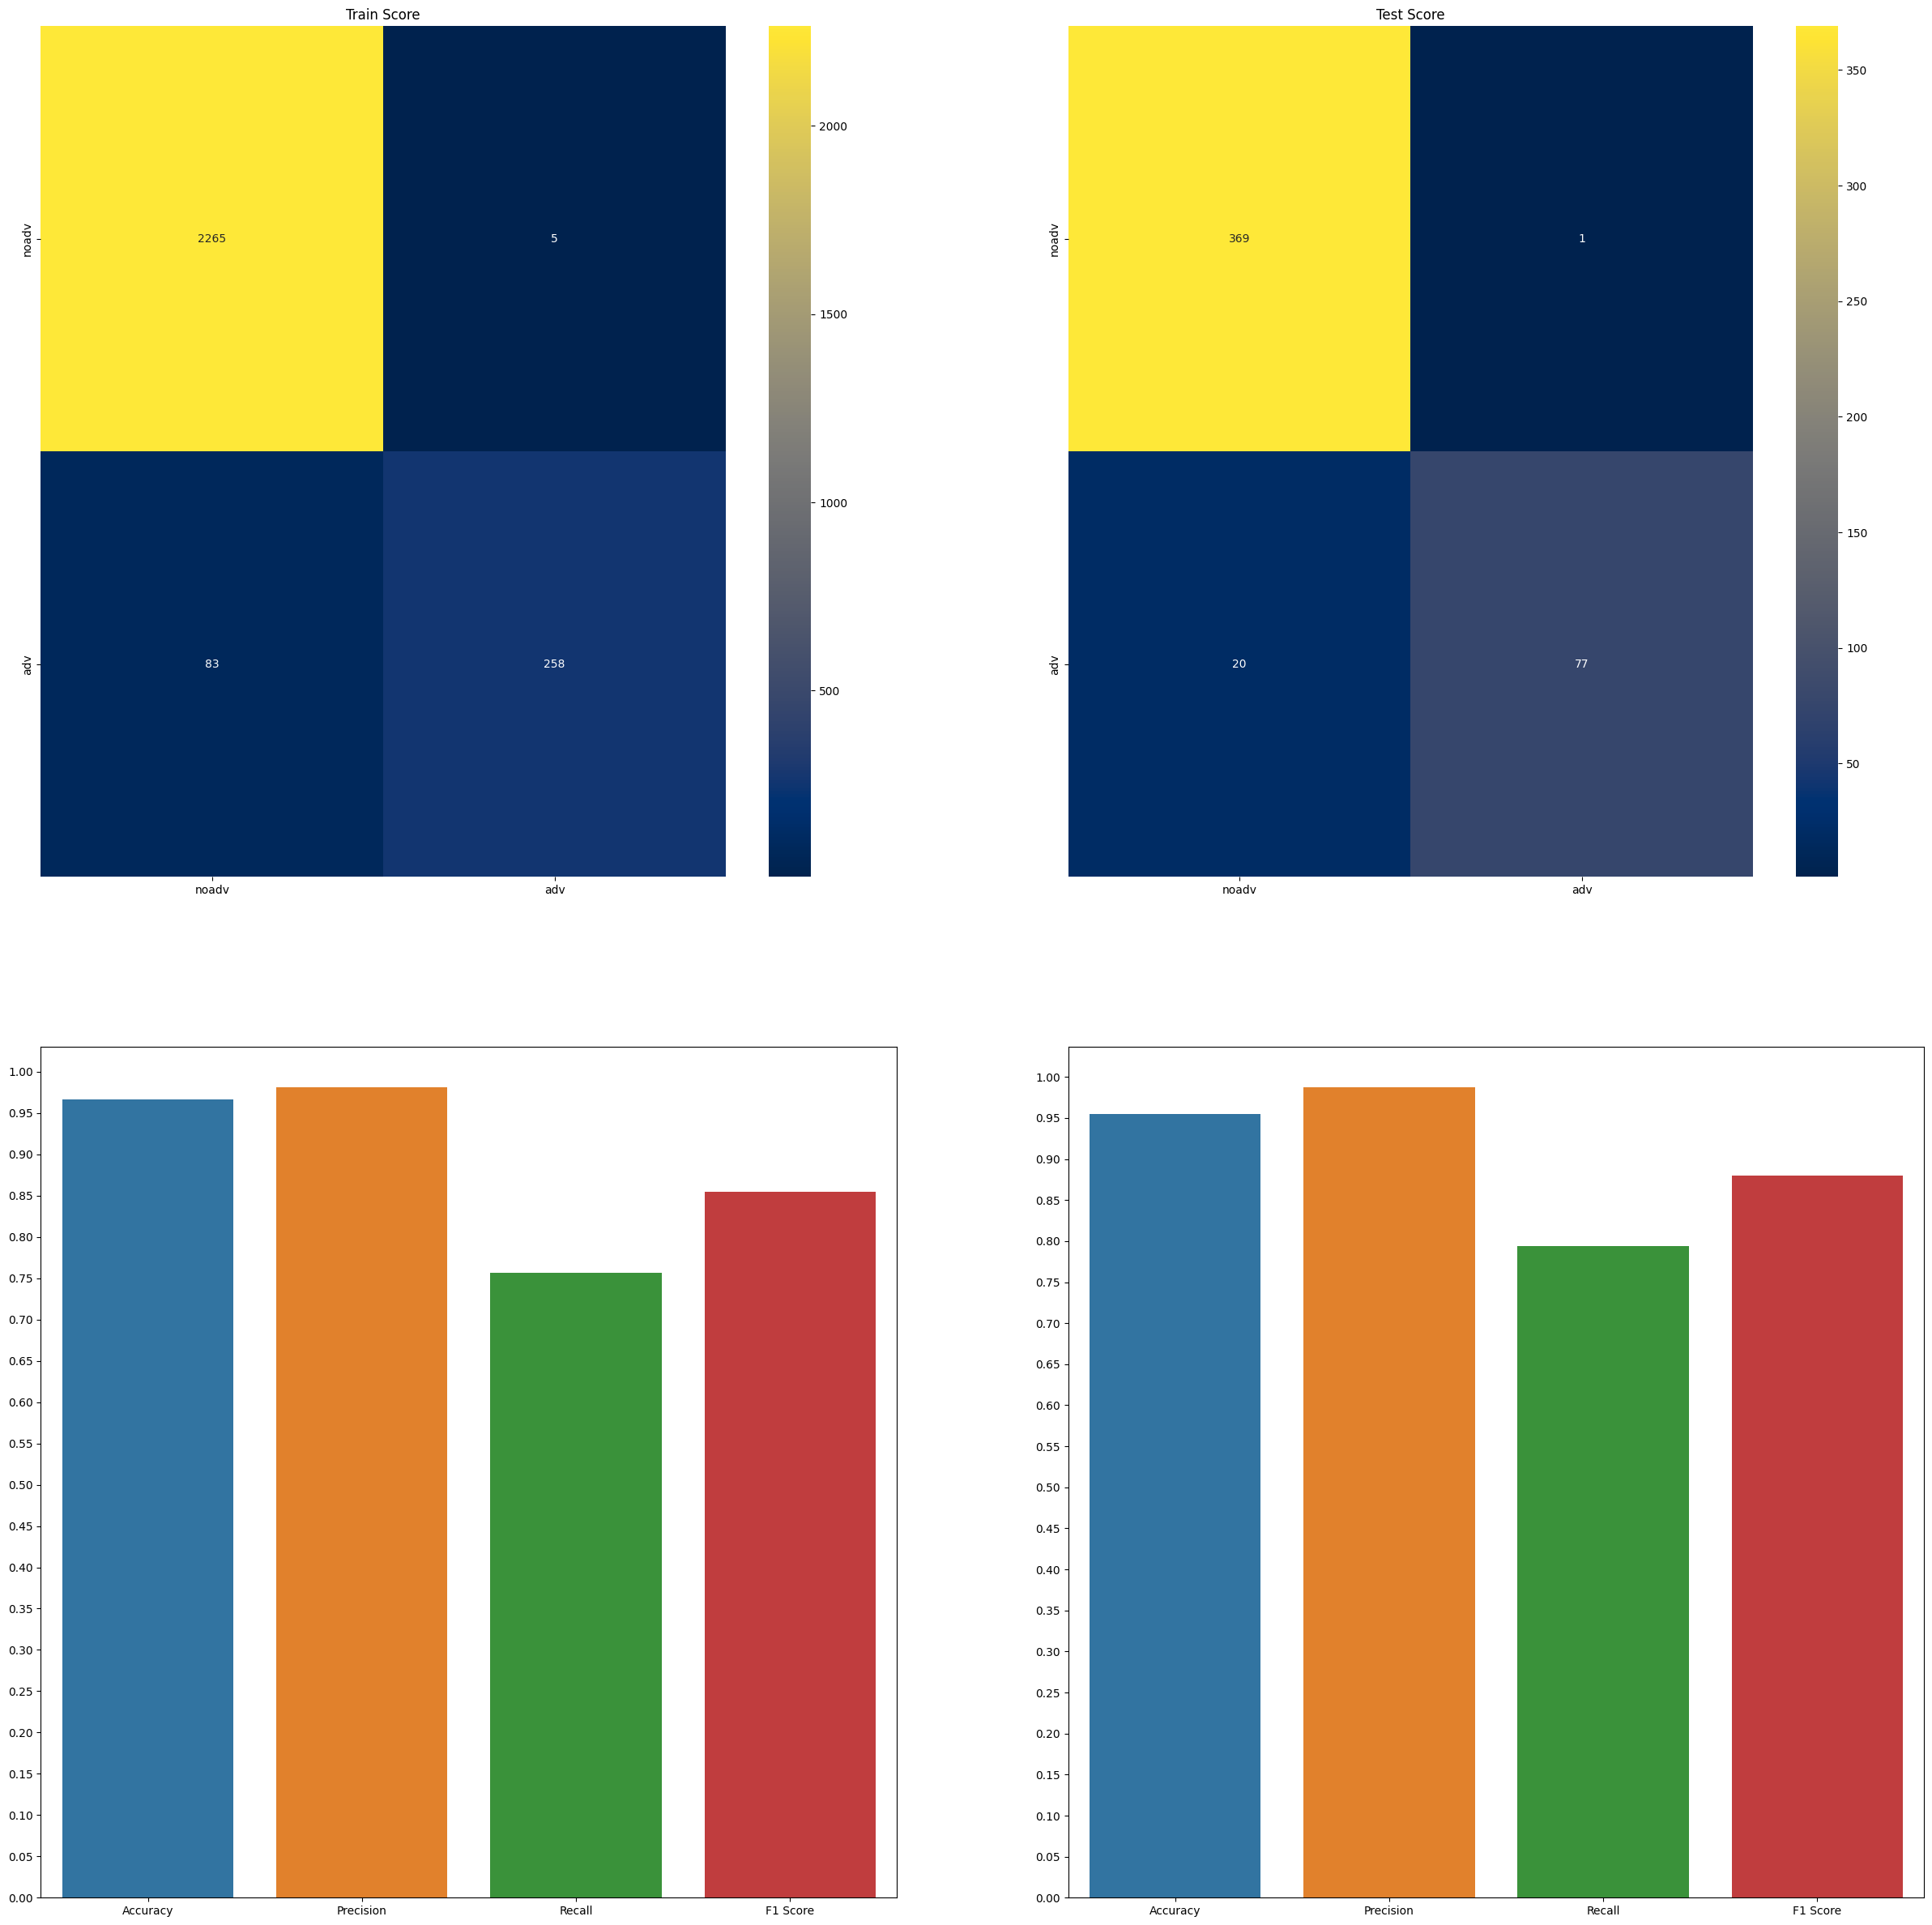

In [104]:
train_probs = pca_model.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

metrics_printer(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

0.9464668094218416


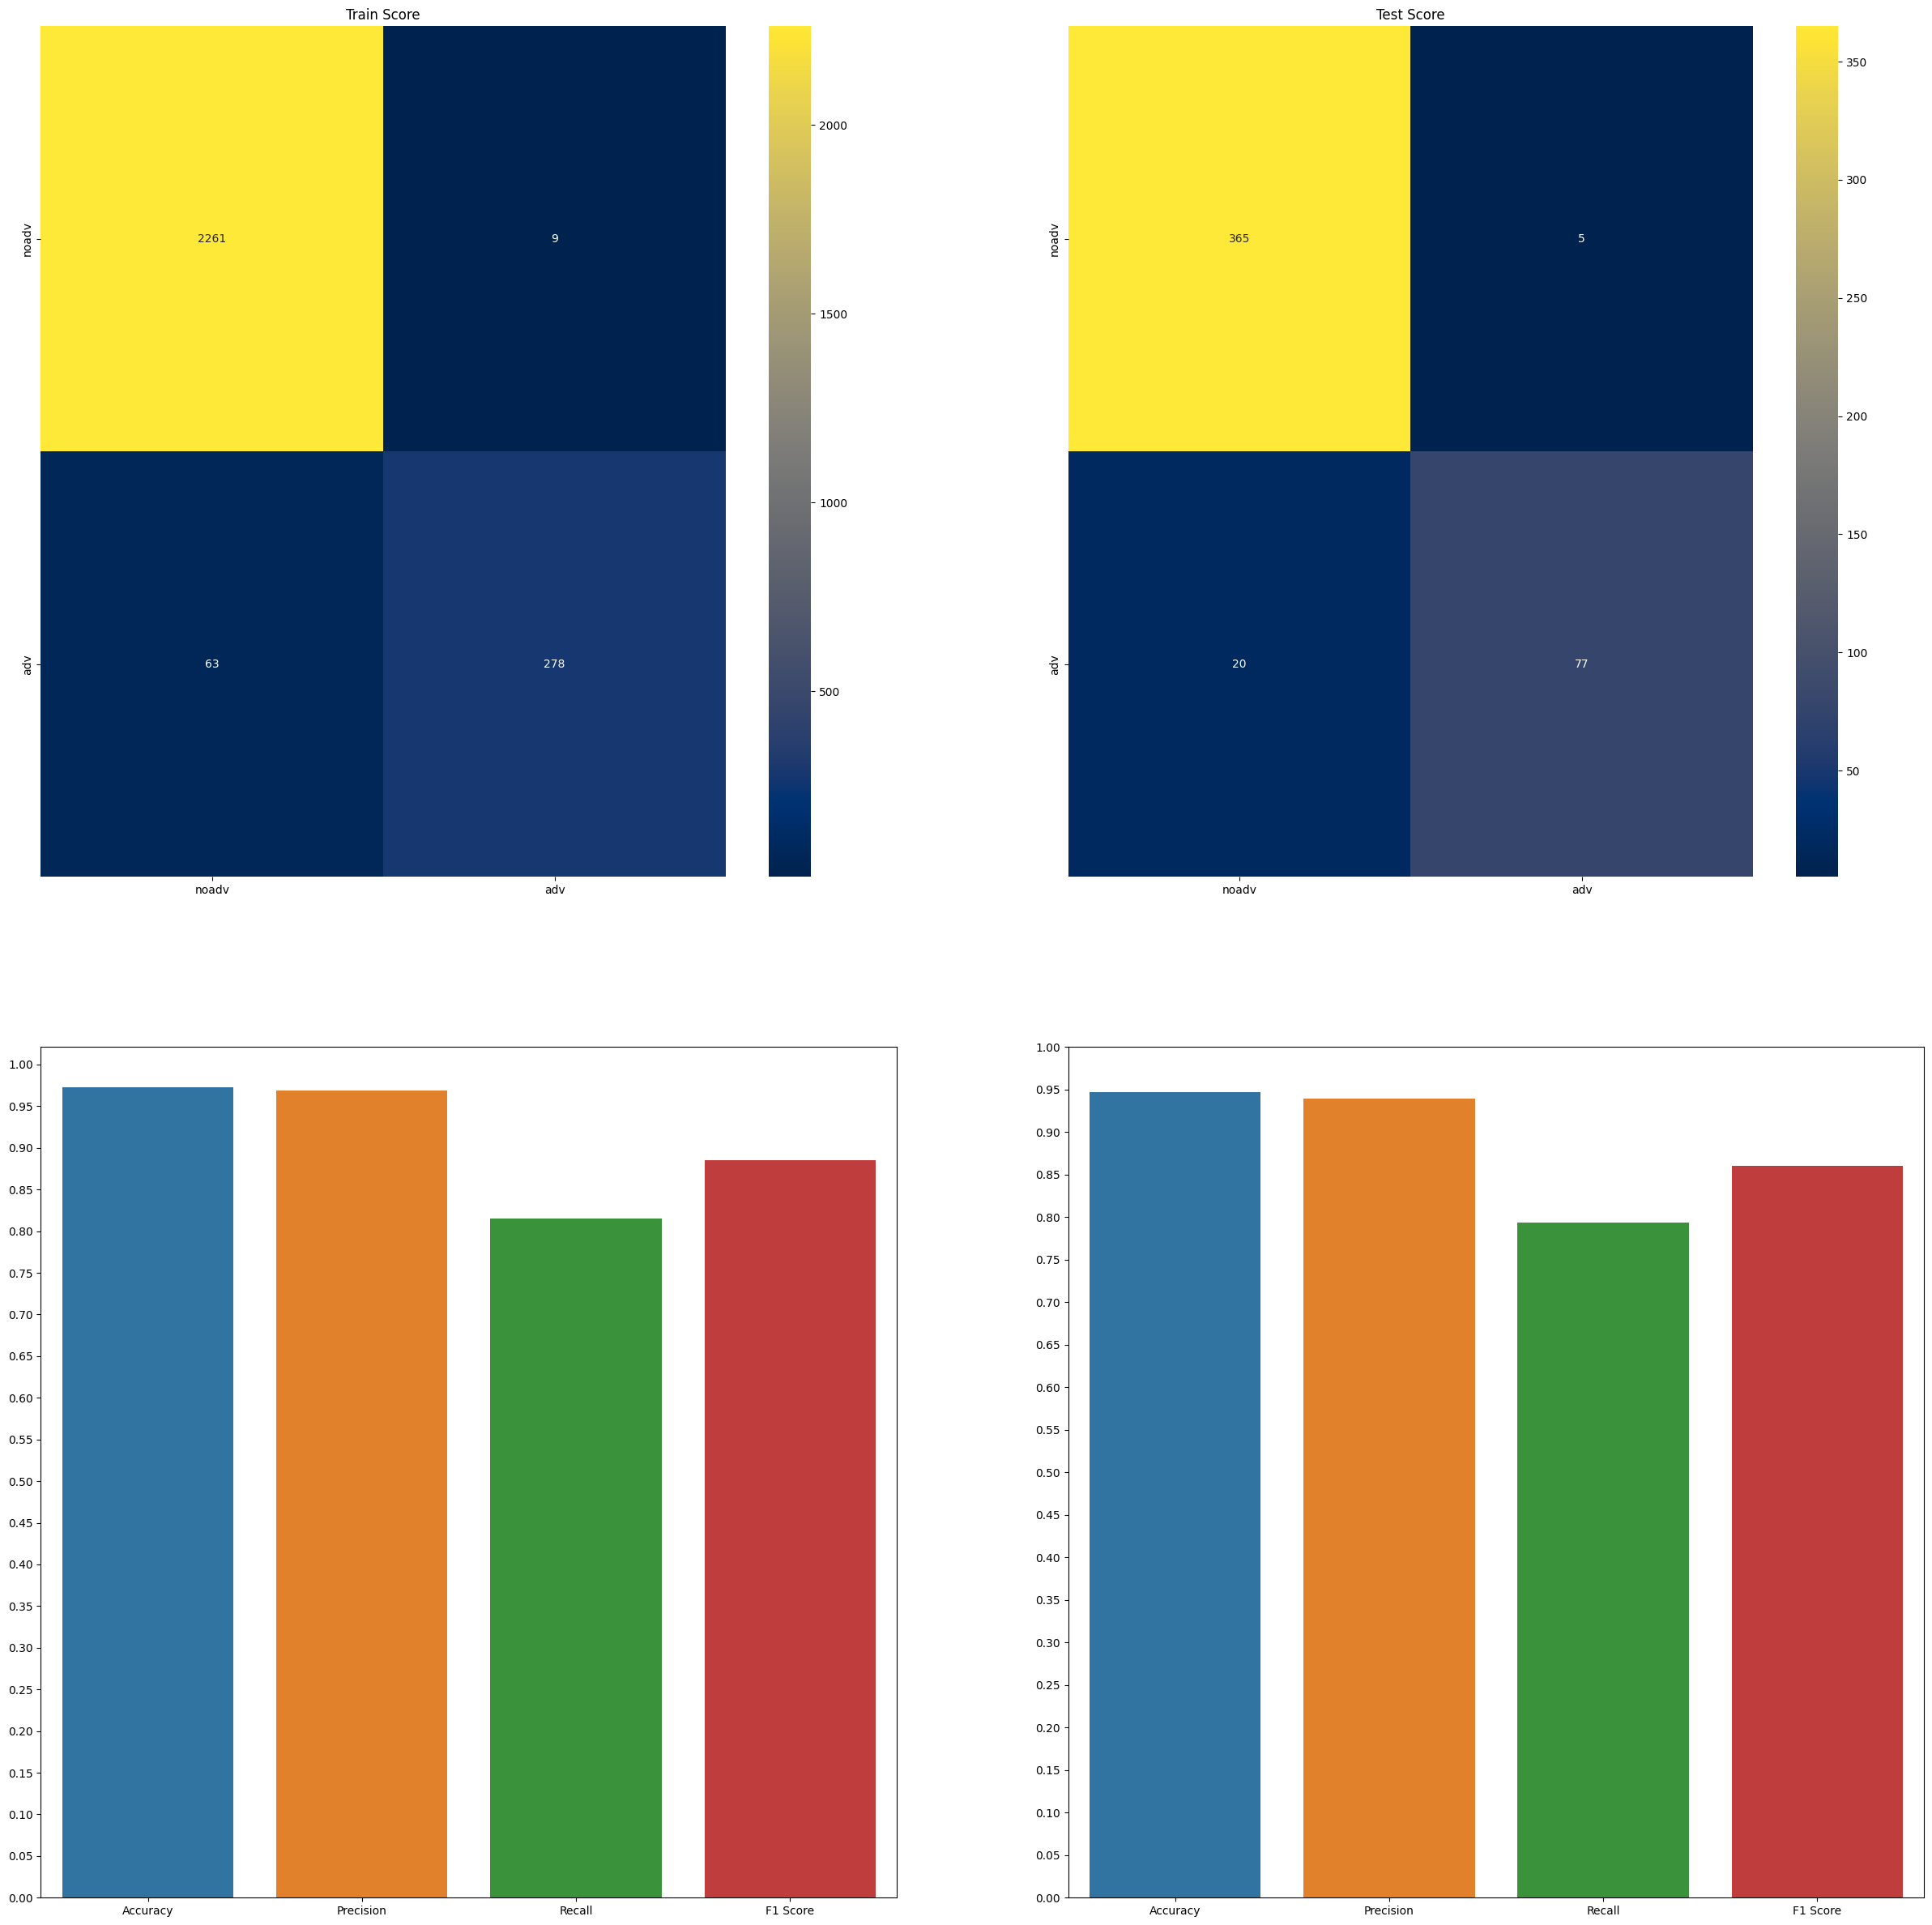

In [74]:
train_probs = pca_model.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

metrics_printer(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

Si noti che sia nel train che nel test set il modello ha una accuracy elavata. Si ha una precisione elevata e una recall più bassa, ciò indica che il modello in questo caso ha una risposta più perdonante, ovvero alcuni adv vengono erroneamente indicati come noadv, ovvero FN > FP. E' un comportamento effettivamente atteso in quanto il dataset risulta sbilanciato verso noadv, come prima analizzato nella sezione analisi precedente.

# Bilanciamento del dataset di training <a id="bilanciamento-dataset"></a>

Viene scelto l'algoritmo SMOTE per generare campioni sintetici in modo da bilanciare il dataset. Considerare di fare un po' di undersampling e poi bilanciare, magari generare troppi dati sintetici è controproducente... intanto si procede senza undersampling.

In [ ]:
# capire se aggiungere o meno undersampling della classe 0 prima di generare i dati sintetici, troppi dati sintetici possono portare overfitting o bias
#per semplificare le operazioni seleziono un numero ancora più ristretto di record
# s_cc = cc[cc.Class==1].copy() #creo un dataset con tutti i dati della classe 1
# s_cc = pd.concat([s_cc, cc[cc.Class==0].sample(n=3000).copy()]) #aggiungo 3000 record per la classe 0

In [ ]:
X_resampled, y_resampled = SMOTE(k_neighbors=5).fit_resample(pca_train_set.drop('Class', axis=1), pca_train_set.Class)
pca_train_set_resampled = pd.concat([X_resampled, y_resampled.rename('Class')], axis=1)

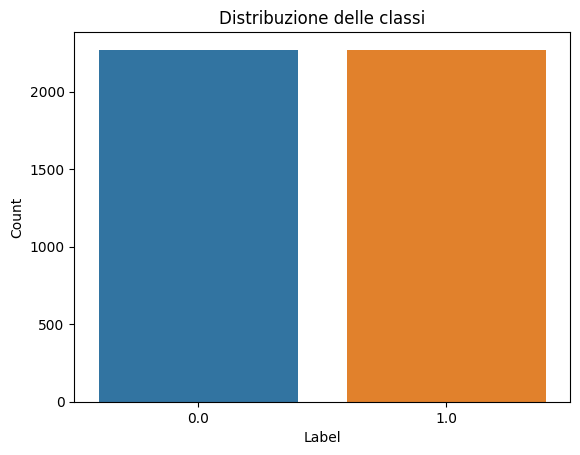

In [ ]:
sns.countplot(data=pca_train_set_resampled, x='Class')
plt.xClass('Class')
plt.yClass('Count')
plt.title('Distribuzione delle classi')
plt.show()

Viene effettuato SMOTE anche sul train set originale:

In [ ]:
X_resampled, y_resampled = SMOTE(k_neighbors=5).fit_resample(train_set_categories.drop('Class', axis=1), train_set_categories.Class)
train_set_categories_resampled = pd.concat([X_resampled, y_resampled.rename('Class')], axis=1)

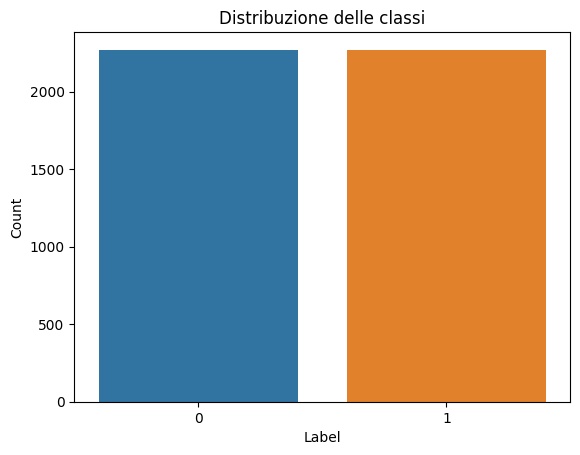

In [ ]:
sns.countplot(data=train_set_categories_resampled, x='Class')
plt.xClass('Class')
plt.yClass('Count')
plt.title('Distribuzione delle classi')
plt.show()

# Futuro

dopo:  Regression, Support Vector Classifier, KNN classifier, 
prima e dopo: Random Forest
Classifier prima e dopo

plot x variabili contare gli 1 in x

contare varianza feature